# Function Definitions

In [2]:
class Sos_graph:
    # an object of this class contains 1) a sage.graphs.graph.Graph object, 2) a dict from node number to label number
    #                                  3) a dict from label number to node number, 4) a boolean if graph is unlabelled
    def __init__(self, sage_graph, node_to_label, label_to_node, is_unlabeled):
        self.sage_graph = sage_graph 
        self.node_to_label = node_to_label
        self.label_to_node = label_to_node
        self.is_unlabeled = is_unlabeled
        
# For the rest of this notebook, I would refer "labels" as the labels we put on the partially labelled graphs, 
# and "vertex nums" as the internal number of a vertex in the sage graph object.

# When I use "sg1" or "sg2" I usually refer to this Sos_graph object.
# When I use "g1" or "g2" I usually refer to the sage graph object.

#This notebook also never considers the existence of lone vertices. 

In [3]:
# Multiplies the two partially labeled graphs and does [[.]] operation on the product.

# Assumes that the arguments have different vertex numbers.

# First finds the common labels in the two partially labeled graphs, then changes the vertex numbers of one of the graphs
# such that the nodes with the same labels have the same vertex numbers.

# Then adding the edge sets of the two graphs "glues" the two graphs.

def gluing2(sg1, sg2):
    samelabels = set(sg1.label_to_node.keys()).intersection(set(sg2.label_to_node.keys())) 
    if sg1.is_unlabeled or sg2.is_unlabeled or (samelabels == set()):
        return Graph(sg1.sage_graph.edges() + sg2.sage_graph.edges(), immutable=True) 
    temp = sg1.sage_graph.copy()
    for label in samelabels:
        temp.relabel({sg1.label_to_node[label]:sg2.label_to_node[label]}) 
    return Graph(temp.edges() + sg2.sage_graph.edges(), immutable=True)

In [4]:
# Squares a given partially labeled graph and does [[.]] operation on the product.

# Creates a copy of the given graph with different vertex nums, and uses gluing.

def square2(sg1):
    g1_copy = sg1.sage_graph.copy()
    label_to_node_copy = sg1.label_to_node.copy()
    node_to_label_copy = sg1.node_to_label.copy()
    is_unlabeled_copy = sg1.is_unlabeled
    sg1_copy = Sos_graph(g1_copy, node_to_label_copy, label_to_node_copy, is_unlabeled_copy)
    new_vertex_num(sg1, sg1_copy)
    return gluing2(sg1, sg1_copy)

In [5]:
# Given two partially labeled graphs with overlapping vertex nums, this function changes the vertex numbers of one of them such
# that the vertex numbers are non-overlapping to use gluing.

def new_vertex_num(sg1, sg2):
    a = max(sg1.sage_graph.vertices(), default=0) + max(sg2.sage_graph.vertices(), default=0)
    l = sg2.sage_graph.vertices()
    for i in l:
        sg2.sage_graph.relabel({i:a+1+i})
    temp = {}
    for i in sg2.label_to_node:
        sg2.label_to_node[i] = sg2.label_to_node[i] + a+1
        temp[sg2.label_to_node[i]] = i
    sg2.node_to_label = temp

In [6]:
# Given two sage graphs, this checks if they have any overlapping vertex numbers. 

# Makes the use of new_vertex_num reduced so that the numbers don't explode after its repeated use.

# True means there is overlapping vertex numbers

def check_matching_2(g1, g2):
    v1 = set(g1.vertices())
    v2 = set(g2.vertices())
    same = v1.intersection(v2)
    if not same:
        return False
    return True

In [7]:
# Gets all connected graphs with e edges. 

def get_connected(e):
    a = list(graphs(e+1, size=e, augment = 'vertices'))
    b = []
    for i in a:
        if i.is_connected():
            b.append(i)
    return b

In [8]:
# Equivalent to new_vertex_num, but here the argument and the output is just a sage_graph.

# Use case is generating disconnected graphs in all_num_edges.

def relabeling_gen(g1, g2):
    a = max(g1.vertices(), default=0) + max(g2.vertices(), default=0)
    l = g2.vertices()
    for i in l:
        g2.relabel({i:a+1+i})

In [9]:
# Returns all graphs with e edges. 

# Uses get_connected to find the connected graphs.
# Finds the disconnected graphs through all non-isomorphic combinations of smaller all_num_edges(i) and all_num_edges(e-i)

def all_num_edges(e):
    x = get_connected(e)
    if e == 1:
        return x
    for i in range(1, e//2 + 1):
        y = all_num_edges(i)
        z = all_num_edges(e - i)
        for j in y:
            for k in z:
                if check_matching_2(j, k):
                    relabeling_gen(j, k)
                t = Graph(j.edges() + k.edges())
                flag = 0
                for m in x:
                    if t.is_isomorphic(m):
                        flag = 1
                        break
                if flag == 0:
                    x.append(t)
    if e == 0:
        return [x[0]]
    return x

In [10]:
# Returns all subsets of a given list. 

# Ex sub_lists([1,2,3]) = [[], [1], [2], [1, 2], [3], [1, 3], [2, 3], [1, 2, 3]]

def sub_lists(l):
    base = []  
    lists = [base]
    for i in range(len(l)):
        orig = lists[:]
        new = l[i]
        for j in range(len(lists)):
            lists[j] = lists[j] + [new]
        lists = orig + lists
    return lists

In [11]:
# Given a graph_size (number of edges), a skeleton graph (sage graph) , and a BigL (an int representing the max label number),
# Returns all the partially labeled graphs where the labeled edges can only be the skeleton and all permutations of 
# the rest of the label numbers till BigL. It also returns the squares of those graphs to avoid recomputation as the squares
# are used for Symmetry Reduction.

# Uses Symmetry Reduction to get only the required partially labeled graphs


# Step 1: Take all graphs of size n

# Step 2: For each of those graphs, find the subgraphs that are isomorphic to skeleton

# Step 3: For each of those subgraphs, find all subsets of nodes in the graph that don't share an edge with the subgraph.

# Step 4: Filter the subsets such that no two nodes in a subset has an edge between them.

# Step 5: Label the graphs with all Permutations and add only the necessary ones (Symmetry Reduction) in the list to return.


# Note: Permutations(remlabels, len(subrest)) has all permutations of the labels being applied.
#       And g.subgraph_search_iterator goes through all permutations of the subgraph to label. 
#       So I wonder if I only need Combinations(remlabels, len(subrest))


def all_labels(graph_size, skeleton, bigL):
    
    allg = all_num_edges(graph_size)
    toret = []
        
# Step 1

    for g in allg:
        if g.subgraph_search_count(skeleton) == 0:
            continue
        labelg = []
        squares = []
        
# Step 2 + Step 3

        for subg in g.subgraph_search_iterator(skeleton):
            skeleton_away = [] 
            for node in g.vertices():
                if node in subg:
                    continue
                flag = 0
                for node2 in subg:
                    if g.has_edge(node, node2):
                        flag = 1
                        break
                if flag == 0:
                    skeleton_away.append(node)
                    
# Now skeleton_away contains all nodes that are not part of the subgraph isomorphic to skeleton or share an edge with it

            remLabels = [] 
            for i in range(len(subg)+1, bigL+1):
                remLabels.append(i)
            nodes_to_labels = {}
            labels_to_nodes = {}

# Now rem_labels has the labels left after the ones that were used in labelling the skeleton
            
            for j in range(1, len(subg)+1):
                nodes_to_labels[subg[j-1]] = j
                labels_to_nodes[j] = subg[j-1]
            all_subrest = sub_lists(skeleton_away)
            
# Now all_subrest has all the subsets of skeleton_away, and the skeleton is labeled.

            best_subrest = []
            for subrest in all_subrest:
                flag2 = 0
                for n1 in range(len(subrest)):
                    for n2 in range(n1 + 1, len(subrest)):
                        if g.has_edge(subrest[n1], subrest[n2]):
                            flag2 = 1
                            break
                    if flag2 == 1:
                        break
                if flag2 == 0:
                    best_subrest.append(subrest)

# Now best_subrest has all the subsets that meet Step 4 condition                    
                    
            for subrest in best_subrest:
                labelsPermute = Permutations(remLabels, len(subrest))
                
                for p in labelsPermute:
                    temp_nodes_to_labels = nodes_to_labels.copy()
                    temp_labels_to_nodes = labels_to_nodes.copy()
                    for k in range(len(subrest)):
                        temp_nodes_to_labels[subrest[k]] = p[k]
                        temp_labels_to_nodes[p[k]] = subrest[k]
                        
# The two temp variables contain labelling of one permutation on one subset in best_subrest

                    if len(temp_nodes_to_labels) == g.order(): #trivial square
                        continue
            
                    addCand = Sos_graph(g.copy(), temp_nodes_to_labels, temp_labels_to_nodes, not temp_labels_to_nodes)
                    flag3 = 0
                    for uni in range(len(labelg)):
                        if labelg[uni].label_to_node.keys() == addCand.label_to_node.keys():
                            if check_matching_2(labelg[uni].sage_graph, addCand.sage_graph):
                                new_vertex_num(labelg[uni], addCand)
                            if gluing2(labelg[uni], addCand).is_isomorphic(squares[uni]):
                                flag3 = 1
                                break
                    
# The above was the symmetry reduction step.
# We check if the product of this graph with any of the existing graphs is isomorphic to the square of that existing graph  

                    tempsquare = square2(addCand)
                    if not tempsquare.size() == 2*graph_size - skeleton.size(): 
                        #Another check in case there are more labeled edges in the chosen subgraph
                        continue
                    if flag3 == 0:
                        labelg.append(addCand)
                        squares.append(tempsquare)
        toret.append((labelg, squares))
    return toret

In [12]:
# Creates all candidate labeled graphs to generate binomials for sums of squares expressions for n-edge graph inequalities.

# So we choose temp, such that temp + temp - k = n since the skeleton of size k stays the same and we want the product of these 
# graphs to be of size n.

# We choose bigL with the reasoning that: 
# After labelling all of the skeleton, we are left with (temp - k) labels. The most labels required would be in the binomial
# (skeleton * edge^(temp - k) - skeleton * edge^(temp - k)) such that each edge that is not in the skeleton has one label and it is a different label

# Observation: the skeleton size (k) is always the same parity as n.

def create_all_candidates(n):
    allCandidates = []
    k = n%2
    while k < n:
        k_edges = all_num_edges(k)
        for skel in k_edges:
            temp = (n+k)//2
            
            #print statement to track progress
            print([n, k, temp, skel.order() + 2*(temp-k)])
            
            allCandidates.append(all_labels(temp, skel, skel.order() + 2*(temp - k)))
        k += 2
    return allCandidates

In [13]:
# Given an allCandidates variable, estimates around how many coefficients would be created for the linear program to run on.

def coeff_estimator(allCandidates):
    ctr = 0
    for skel in range(len(allCandidates)):
        temp = 0
        for g1 in range(len(allCandidates[skel])):
            temp += len(allCandidates[skel][g1][0])
        ctr += temp**2
    return ctr

In [14]:
# Given an allCandidates variable and a number n for the number of edges in the inequalities we are trying to solve, 
# we generate all binomials having a common skeleton and their effect on each of the n edge graphs.
# the coeffs variable contains a tuple (skel, g1, lg1, g2, lg2) for every such binomial
# the basic variable contains the coefficients 1, or -2 for each binomial for each n-edge graph.


def create_coeffs(allCandidates, n):
    n_edges = all_num_edges(n)
    basic = []
    for i in range(len(n_edges)):
        basic.append([])
    coeffs = []
    
    for skel in range(len(allCandidates)):
        for g1 in range(len(allCandidates[skel])):
            for lg1 in range(len(allCandidates[skel][g1][0])):
                for g2 in range(len(allCandidates[skel])):
                    for lg2 in range(len(allCandidates[skel][g2][0])):
                        if g1==g2 and lg1==lg2:
                            continue
                            
                        if check_matching_2(allCandidates[skel][g1][0][lg1].sage_graph, allCandidates[skel][g2][0][lg2].sage_graph):
                            new_vertex_num(allCandidates[skel][g1][0][lg1], allCandidates[skel][g2][0][lg2])
                            
                        # allCandidates[skel][g1][0][lg1] and allCandidates[skel][g2][0][lg2] are the two labeled graphs we
                        # are considering.
                            
                        gx = gluing2(allCandidates[skel][g1][0][lg1], allCandidates[skel][g2][0][lg2])
                        sq1 = allCandidates[skel][g1][1][lg1]
                        sq2 = allCandidates[skel][g2][1][lg2]
                        
                        # sq1 and sq2 were already computed during creation of allCandidates to reduce recomputation.
                        
                        index1 = 0
                        index2 = 0
                        index3 = 0
                        b1 = False
                        b2 = False
                        b3 = False
                        
                        #for loop to find the index of all the three graphs
                        
                        for i in range(len(n_edges)):
                            if b1 and b2 and b3:
                                break
                            if n_edges[i].is_isomorphic(gx):
                                index1 = i
                                b1 = True
                            if n_edges[i].is_isomorphic(sq1):
                                index2 = i
                                b2 = True
                            if n_edges[i].is_isomorphic(sq2):
                                index3 = i
                                b3 = True
                                
                        #The above for loop uses 3 booleans so that if all three graphs are found, it stops.
                        
                        basic[index1].append((int(-2), (int(skel), int(g1), int(lg1), int(g2), int(lg2))))
                        basic[index2].append((int(1), (int(skel), int(g1), int(lg1), int(g2), int(lg2))))
                        basic[index3].append((int(1), (int(skel), int(g1), int(lg1), int(g2), int(lg2))))
                        coeffs.append((int(skel), int(g1), int(lg1), int(g2), int(lg2)))
                        
                        # Prints length of coeffs at every 10000 instances to track progress.
                        if len(coeffs) % 10000 == 0:
                            print(len(coeffs))
                            
    return basic, coeffs

In [15]:
#Given the allCandidates variable, coef_numbers

def print_Sos(allCandidates, coef_numbers, coeffs):
    for i in range(len(coef_numbers)):
        print("(")
        x = coeffs[coef_numbers[i]]
        allCandidates[x[0]][x[1]][0][x[2]].sage_graph.show()
        print(allCandidates[x[0]][x[1]][0][x[2]].label_to_node)
        print(" - ")
        allCandidates[x[0]][x[3]][0][x[4]].sage_graph.show()
        print(allCandidates[x[0]][x[3]][0][x[4]].label_to_node)
        print(")^2\n\n")

In [16]:
# Given an allCandidates variable and a number n for the number of edges in the inequalities we are trying to solve, 
# we generate all binomials having a common skeleton and their effect on each of the n edge graphs.
# the coeffs variable contains a tuple (skel, g1, lg1, g2, lg2) for every such binomial
# the basic variable contains the coefficients 1, or -2 for each binomial for each n-edge graph.
import gc

def create_coeffs2(allCandidates, n_edges):
    basic = []
    for i in range(len(n_edges)):
        basic.append([])
    coeffs = []
    
    for skel in range(len(allCandidates)):
        for g1 in range(len(allCandidates[skel])):
            for lg1 in range(len(allCandidates[skel][g1][0])):
                for g2 in range(len(allCandidates[skel])):
                    for lg2 in range(len(allCandidates[skel][g2][0])):
                        if g1==g2 and lg1==lg2:
                            continue
                            
                        if check_matching_2(allCandidates[skel][g1][0][lg1].sage_graph, allCandidates[skel][g2][0][lg2].sage_graph):
                            new_vertex_num(allCandidates[skel][g1][0][lg1], allCandidates[skel][g2][0][lg2])
                            
                        # allCandidates[skel][g1][0][lg1] and allCandidates[skel][g2][0][lg2] are the two labeled graphs we
                        # are considering.
                            
                        gx = gluing2(allCandidates[skel][g1][0][lg1], allCandidates[skel][g2][0][lg2])
                        sq1 = allCandidates[skel][g1][1][lg1]
                        sq2 = allCandidates[skel][g2][1][lg2]
                        
                        # sq1 and sq2 were already computed during creation of allCandidates to reduce recomputation.
                        
                        index1 = 0
                        index2 = 0
                        index3 = 0
                        b1 = False
                        b2 = False
                        b3 = False
                        
                        #for loop to find the index of all the three graphs
                        
                        for i in range(len(n_edges)):
                            if b1 and b2 and b3:
                                break
                            if n_edges[i].is_isomorphic(gx):
                                index1 = i
                                b1 = True
                            if n_edges[i].is_isomorphic(sq1):
                                index2 = i
                                b2 = True
                            if n_edges[i].is_isomorphic(sq2):
                                index3 = i
                                b3 = True
                                
                        #The above for loop uses 3 booleans so that if all three graphs are found, it stops.
                        
                        basic[index1].append((int(-2), (int(skel), int(g1), int(lg1), int(g2), int(lg2))))
                        basic[index2].append((int(1), (int(skel), int(g1), int(lg1), int(g2), int(lg2))))
                        basic[index3].append((int(1), (int(skel), int(g1), int(lg1), int(g2), int(lg2))))
                        coeffs.append((int(skel), int(g1), int(lg1), int(g2), int(lg2)))
                        
                        # Prints length of coeffs at every 10000 instances to track progress.
                        if len(coeffs) % 10000 == 0:
                            print(len(coeffs))
                            gc.collect()
                            
    return basic, coeffs

# Example 6 edges

### Need to run these blocks once.

In [ ]:
allCandidates = create_all_candidates(6)
#Prints all n, skeleton_size, graph_size, BigL 

In [ ]:
print(coeff_estimator(allCandidates))

In [ ]:
basic, coeffs = create_coeffs(allCandidates, 6)

In [ ]:
len(coeffs) 

In [ ]:
import pickle
with open('6edgeCoeffs.pkl', 'wb') as f: #Choose pickle file name for the gurobi notebook 
    pickle.dump([basic, coeffs], f)

In [ ]:
save(allCandidates, '6EdgesAllCandidates')

In [ ]:
sixEdges = all_num_edges(6)

In [ ]:
for i in range(len(sixEdges)):
    print(i)
    sixEdges[i].show()

### Only run these blocks for usage later.

In [ ]:
# Let's find (graph 25 - graph 51) = (triangular bipyramid - edge^6). 

# In general, Look for your graph in the above printed list and find its index.

# For our example, let's use these numbers 25, 51 in the gurobi notebook.

In [ ]:
allCandidates = load('6EdgesAllCandidates')

In [ ]:
import pickle
with open('6edgeCoeffs.pkl', 'rb') as f: 
    basic, coeffs = pickle.load(f)

In [ ]:
print_Sos(allCandidates, [2178, 2829, 17066, 40463, 82540, 104914], coeffs) #

# Example 7 edges

In [ ]:
allCandidates = create_all_candidates(7)

In [ ]:
print(coeff_estimator(allCandidates))

In [ ]:
basic, coeffs = create_coeffs(allCandidates, 7)

In [ ]:
len(coeffs) 

In [ ]:
import pickle
with open('7edgeCoeffs.pkl', 'wb') as f: #Choose pickle file name for the gurobi notebook 
    pickle.dump([basic, coeffs], f)

In [ ]:
sevenEdges = all_num_edges(7)

In [ ]:
for i in range(len(sevenEdges)):
    print(i)
    sevenEdges[i].show()

In [ ]:
save(allCandidates, '7EdgesAllCandidates')

### Only run these block for usage later

In [ ]:
# Let's find (graph 0 - graph 130) = (seven star - edge^7). 

# In general, Look for your graph in the above printed list and find its index.

# For our example, let's use these numbers 0, 130 in the gurobi notebook.

In [ ]:
allCandidates = load('7EdgesAllCandidates')

In [ ]:
with open('7edgeCoeffs.pkl', 'rb') as f: 
    basic, coeffs = pickle.load(f)

In [ ]:
print_Sos(allCandidates, [192060, 271990, 310833, 369522, 389382], coeffs)

# Example 8 edges

In [ ]:
allCandidates = create_all_candidates(8)

In [ ]:
save(allCandidates, '8EdgesAllCandidates')

In [20]:
print(coeff_estimator(allCandidates))

23681615


In [ ]:
eightEdges = all_num_edges(8)

In [ ]:
len(eightEdges)

In [ ]:
save(eightEdges, 'allEightEdges')

0


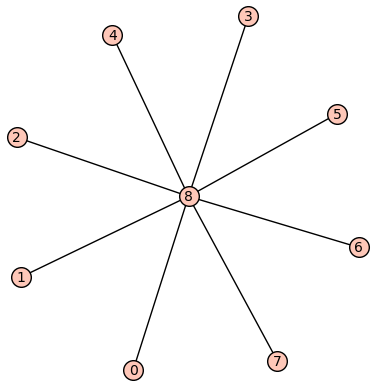

1


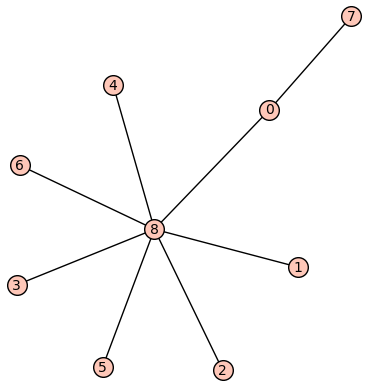

2


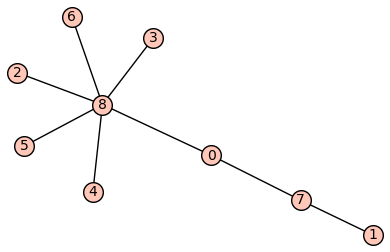

3


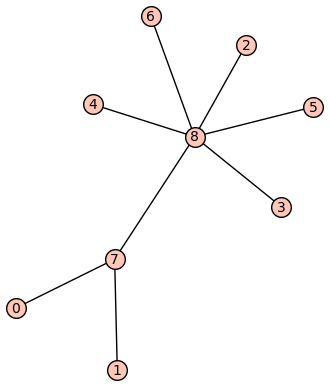

4


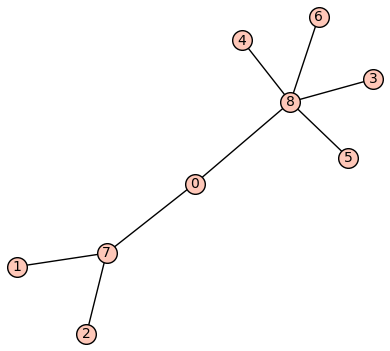

5


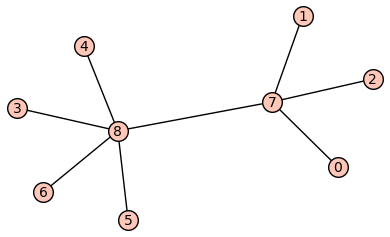

6


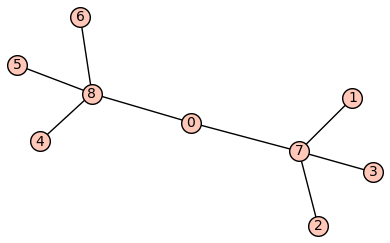

7


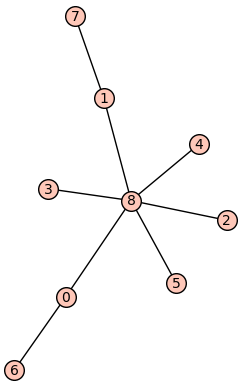

8


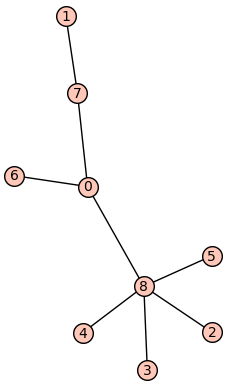

9


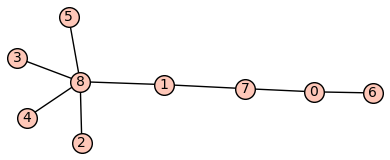

10


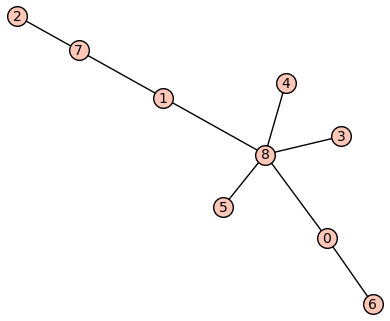

11


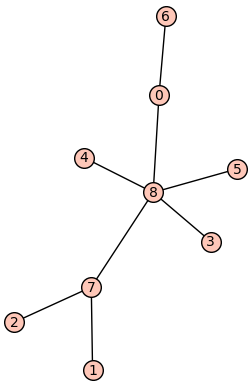

12


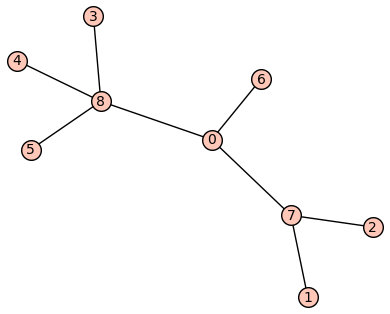

13


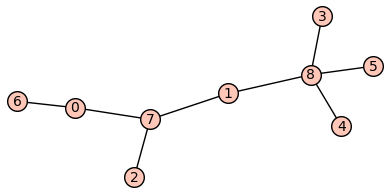

14


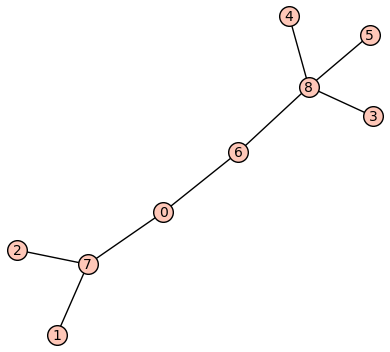

15


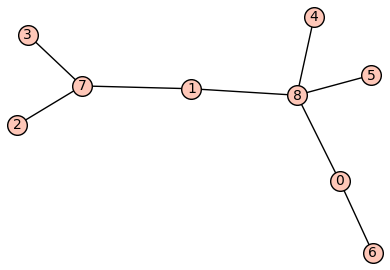

16


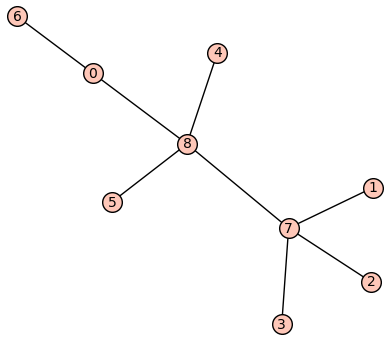

17


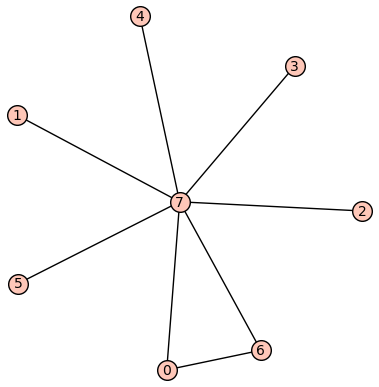

18


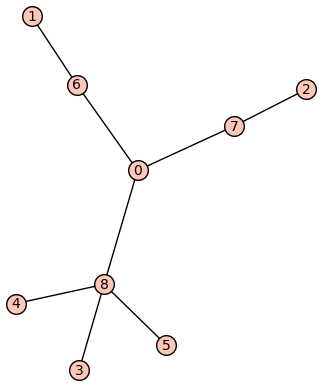

19


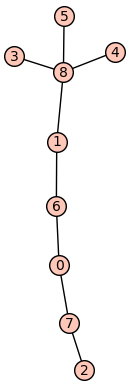

20


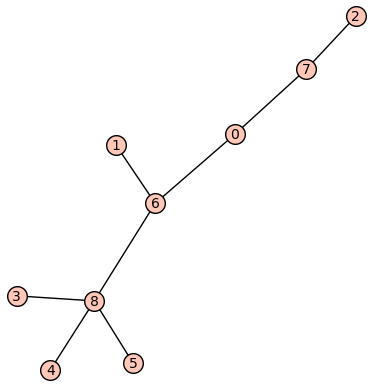

21


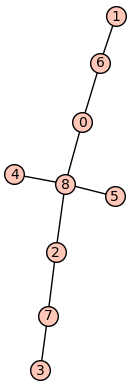

22


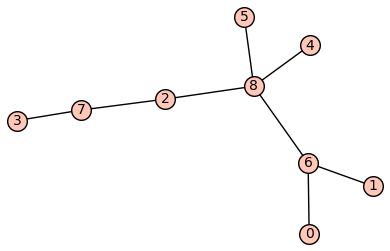

23


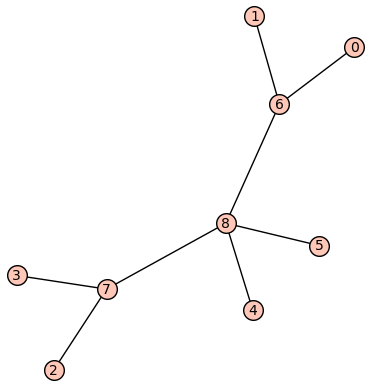

24


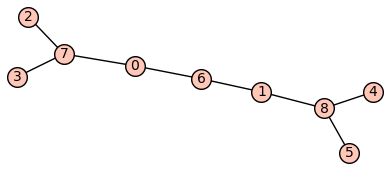

25


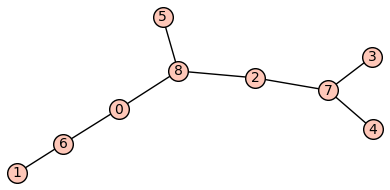

26


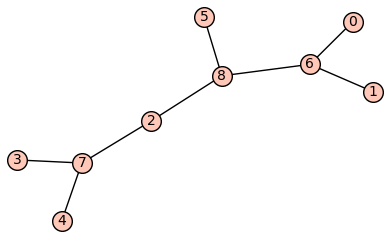

27


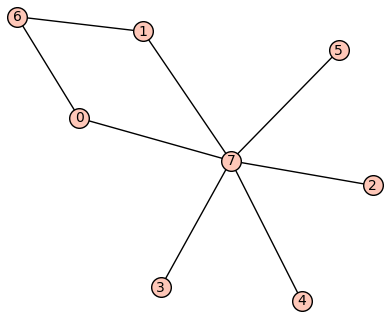

28


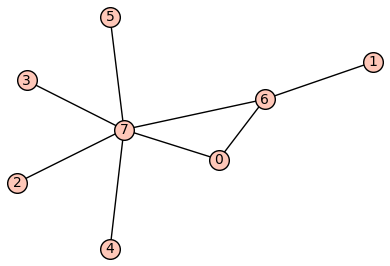

29


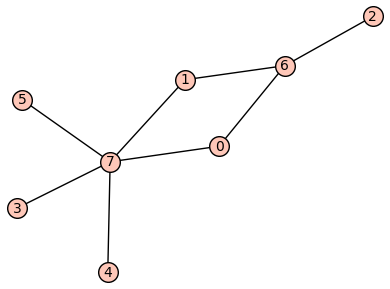

30


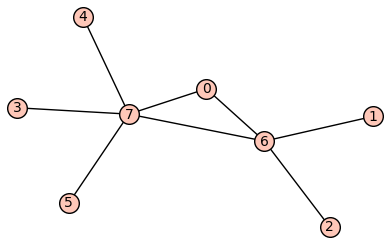

31


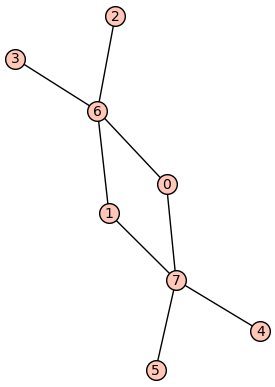

32


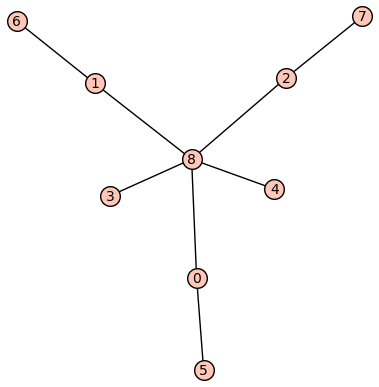

33


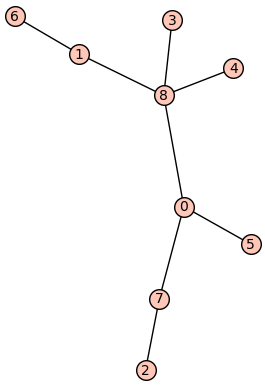

34


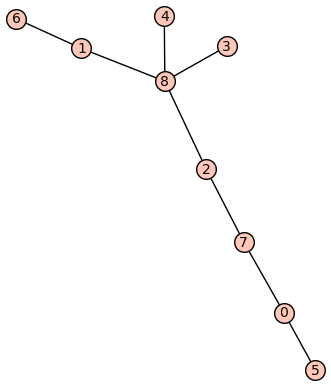

35


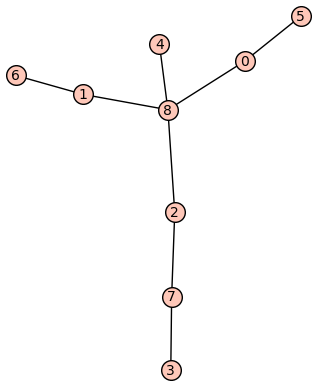

36


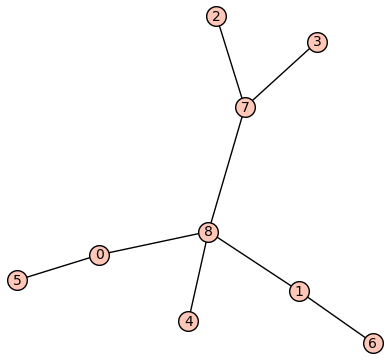

37


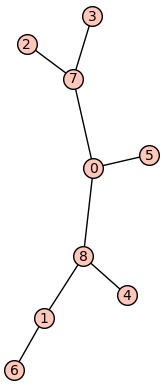

38


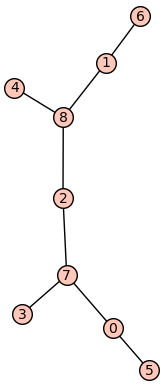

39


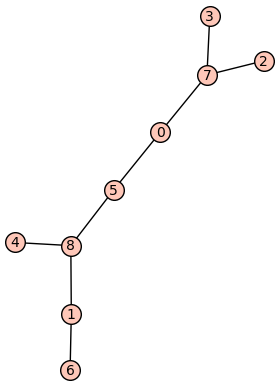

40


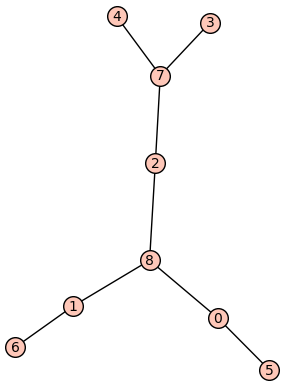

41


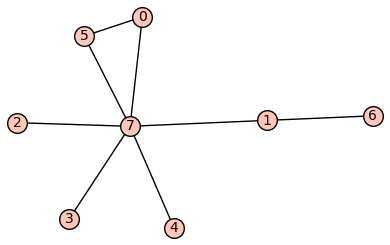

42


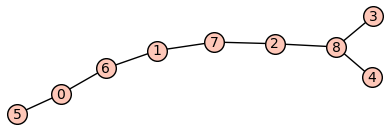

43


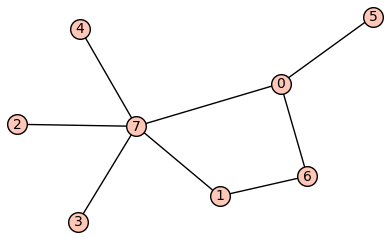

44


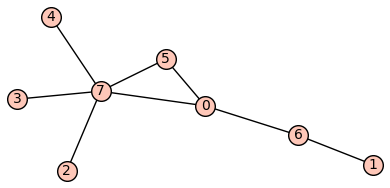

45


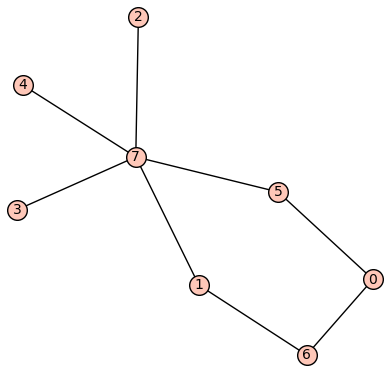

46


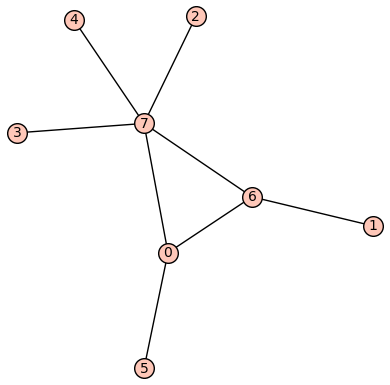

47


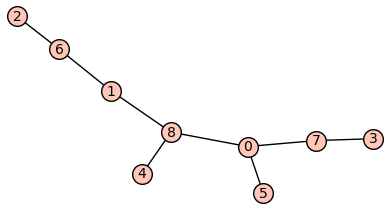

48


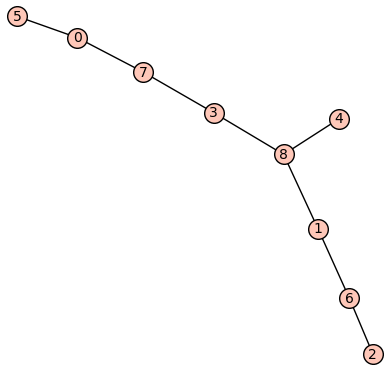

49


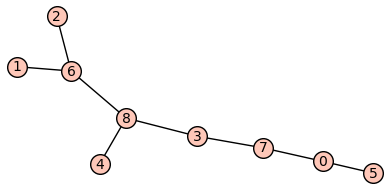

50


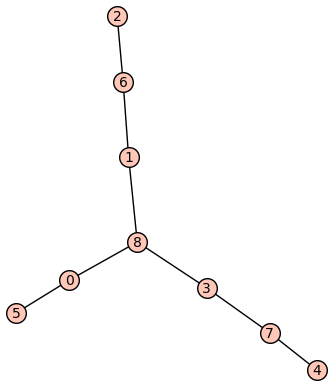

51


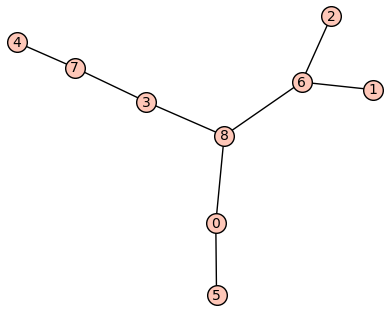

52


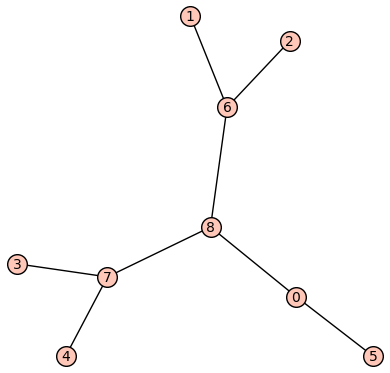

53


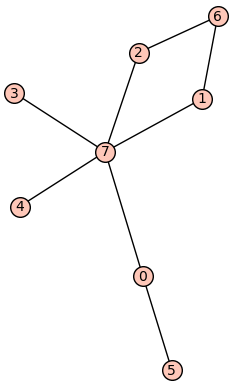

54


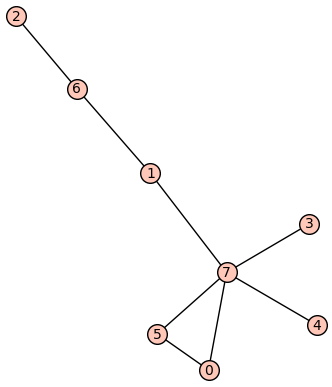

55


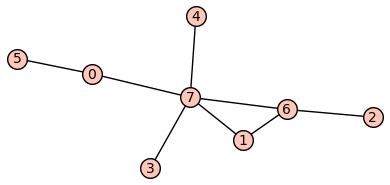

56


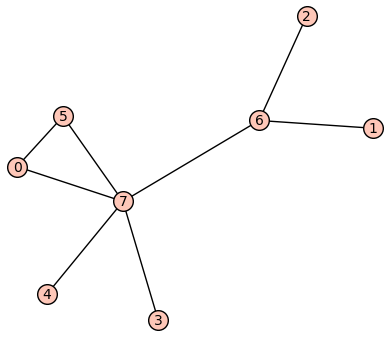

57


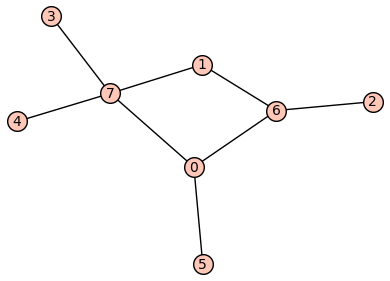

58


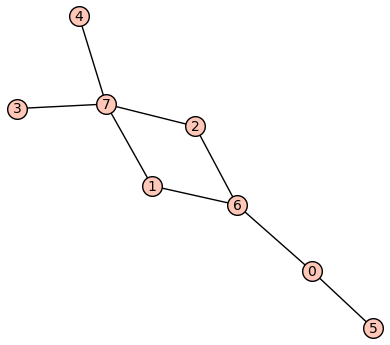

59


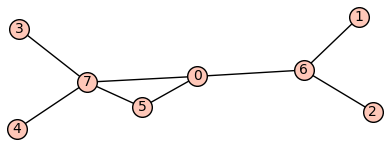

60


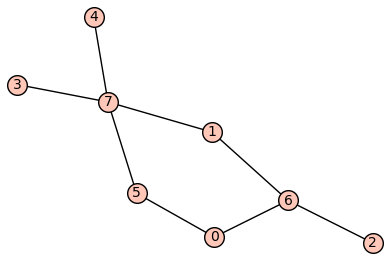

61


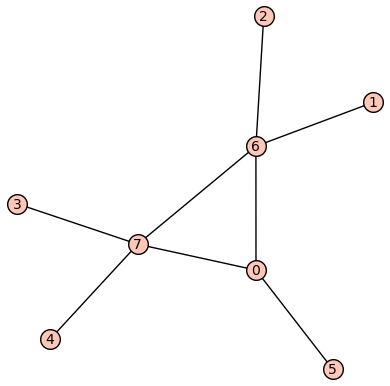

62


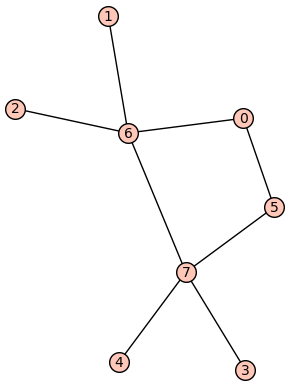

63


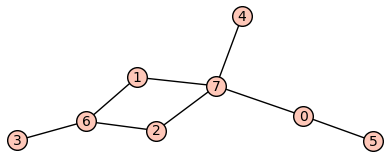

64


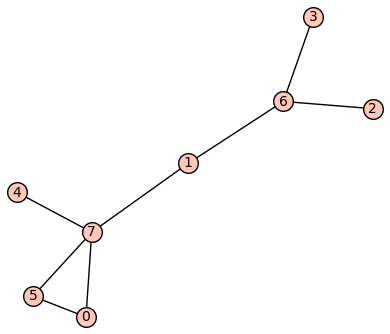

65


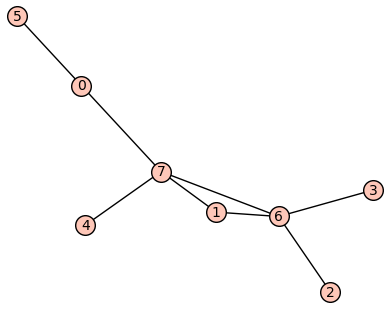

66


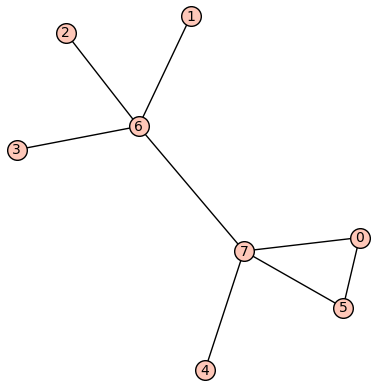

67


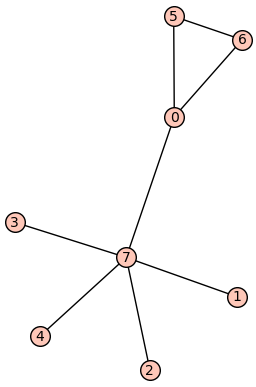

68


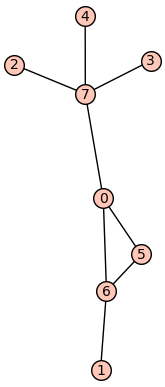

69


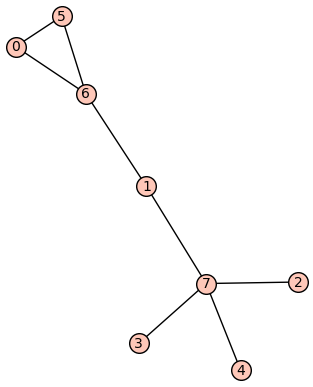

70


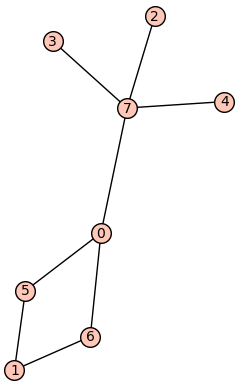

71


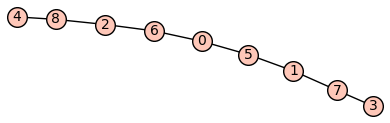

72


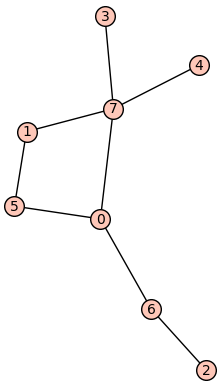

73


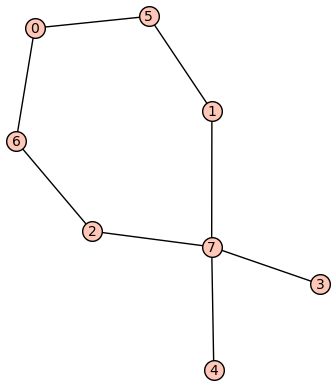

74


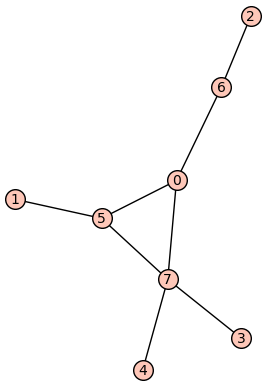

75


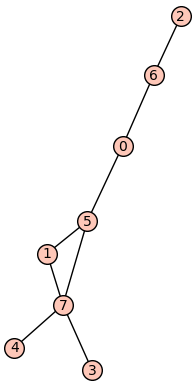

76


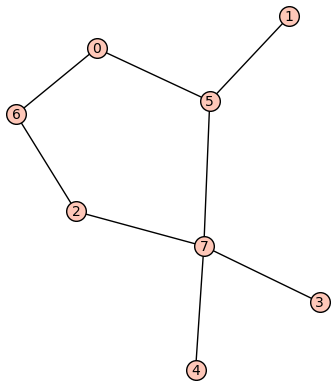

77


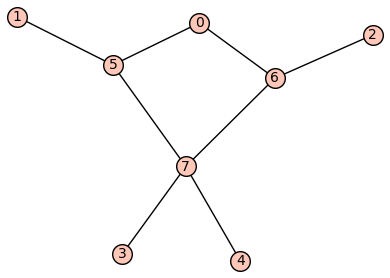

78


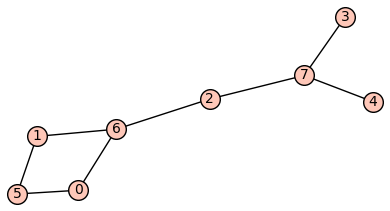

79


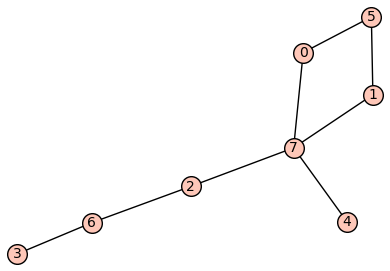

80


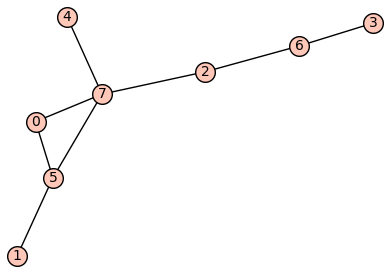

81


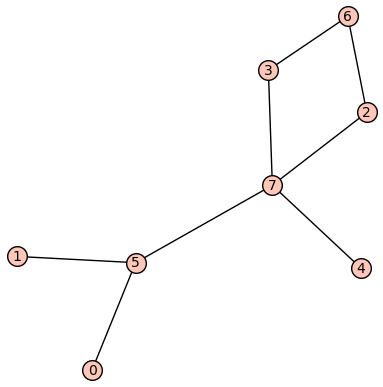

82


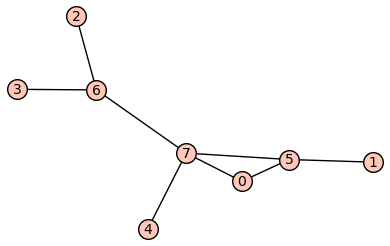

83


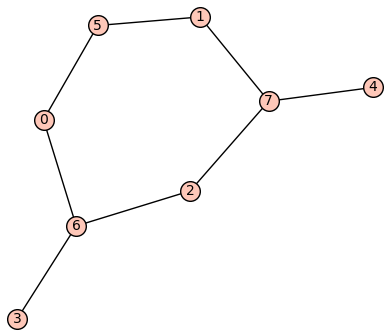

84


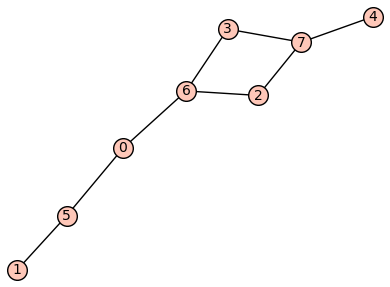

85


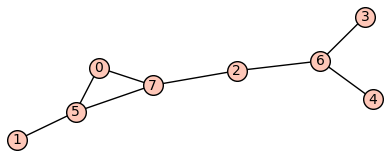

86


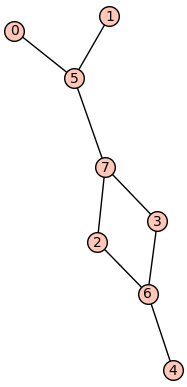

87


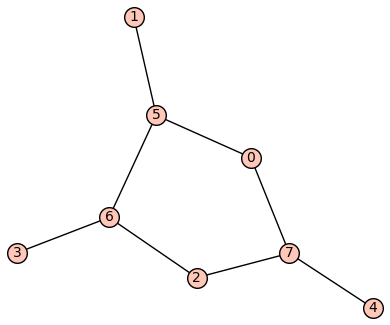

88


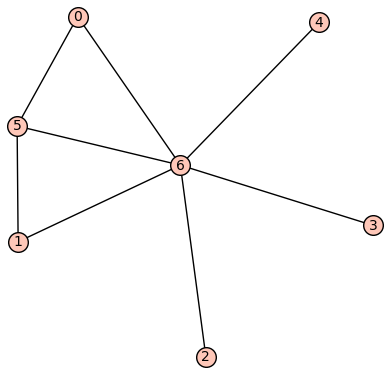

89


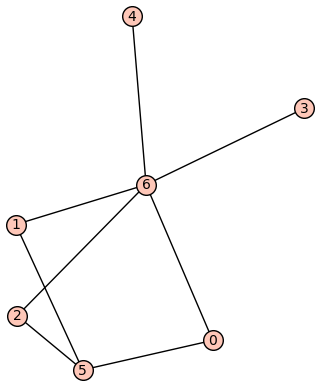

90


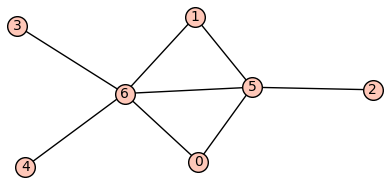

91


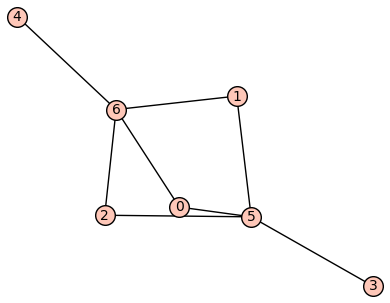

92


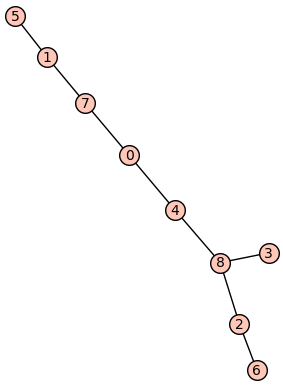

93


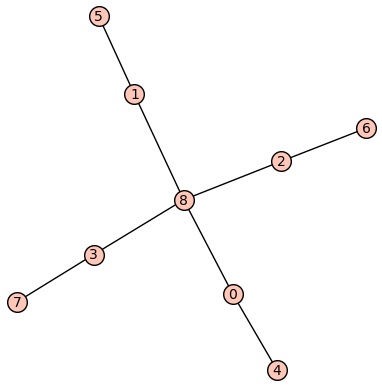

94


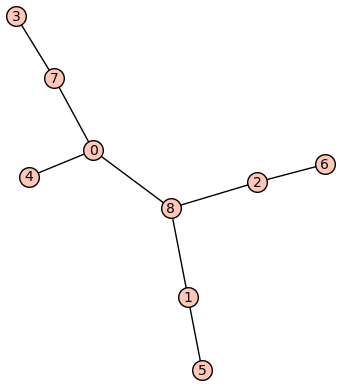

95


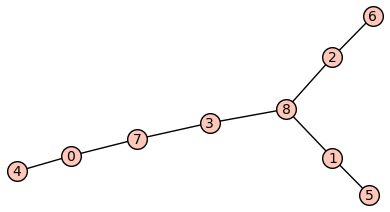

96


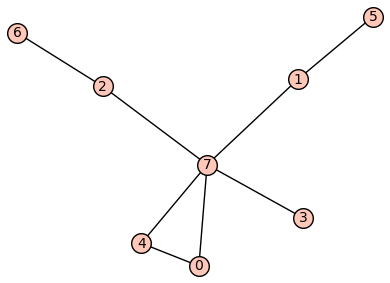

97


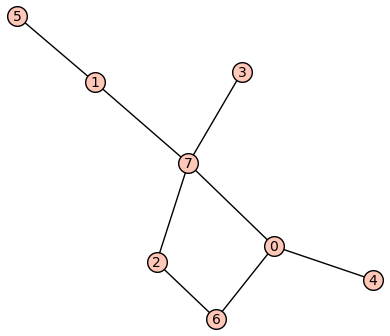

98


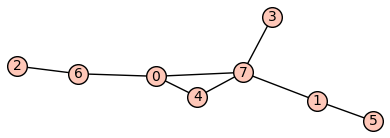

99


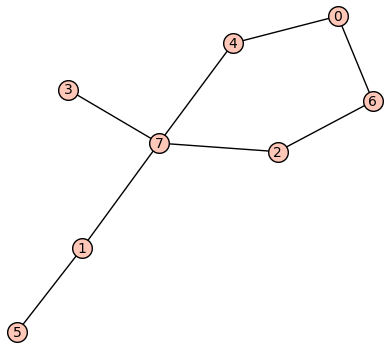

100


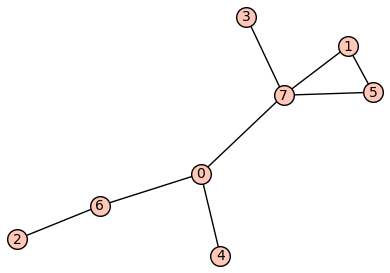

101


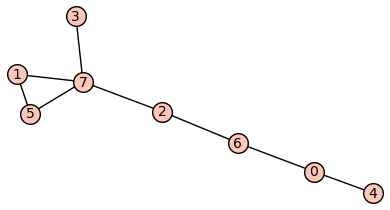

102


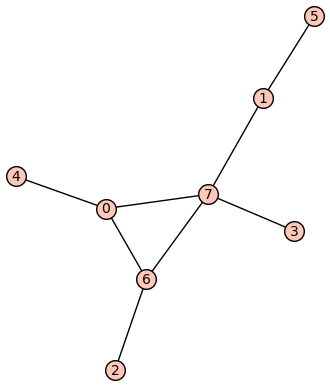

103


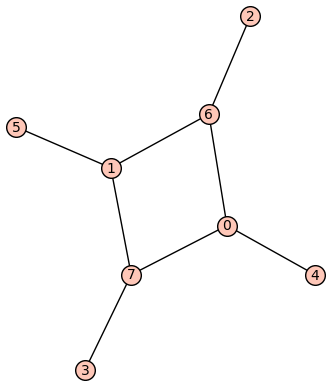

104


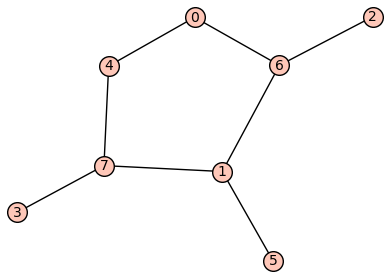

105


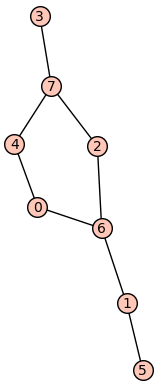

106


KeyboardInterrupt: 

In [19]:
for i in range(len(eightEdges)):
    print(i)
    eightEdges[i].show()

In [ ]:
# Start time 7:38 AM, 7/1/2022

In [17]:
allCandidates = load('8EdgesAllCandidates')

In [18]:
eightEdges = load('allEightEdges')

In [ ]:
basic, coeffs = create_coeffs2(allCandidates, eightEdges)